# Chapter8 딥러닝

## 8.1 더 깊게

- 심층 신경망을 만들어 MNIST 손글씨 숫자 인식

### 8.1.1 더 깊은 신경망으로

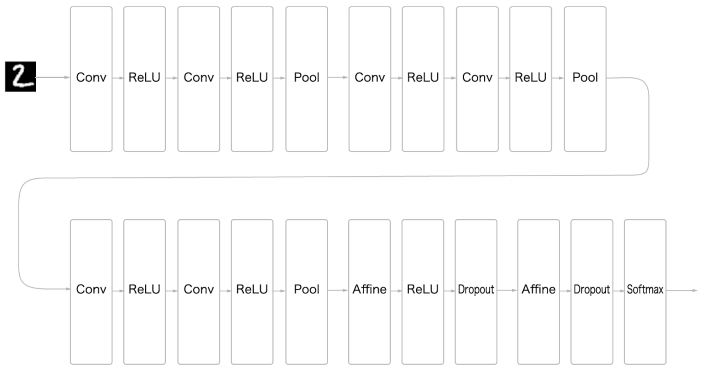

- 3x3 작은 필터 사용한 합성곱 계층
- 활성화 함수 ReLU사용
- 완전연결 계층 뒤에 드랍아웃 사용
- Adam 사용
- 가중치 초깃값은 He


In [1]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch.git

Cloning into 'deep-learning-from-scratch'...
remote: Enumerating objects: 826, done.
remote: Total 826 (delta 0), reused 0 (delta 0), pack-reused 826
Receiving objects: 100% (826/826), 52.21 MiB | 20.81 MiB/s, done.
Resolving deltas: 100% (477/477), done.


In [ ]:
%cd /content/deep-learning-from-scratch/ch08

- 깃헙의 심층 CNN 예제 코드

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *


class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망

    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]


### 8.1.2 정확도를 더 높이려면

- 다양한 데이터셋을 대상으로 사용된 기법과 정확도 순위 사이트
https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d313030

- 순위권 상위 기법들을 참고하면 정확도를 높일 수 있는 팁들을 얻을 수 있다

  - 앙상블 학습, 학습률 감소, 데이터 확장...


### 8.1.3 깊게 하는 이유

- 층을 깊게 할때의 이점
  - 신경망의 매개변수 수가 줄어든다

    ex) 5x5 1회 conv연산보다 3x3의 2회 conv연산이 필요한 매개변수의 수가 더 적다 (25 vs 18) => 큰 필터로 층 한번 거치는 것보다 작은 필터로 여러 층을 거치는것이 연산이 더 적으면서도 활성화 함수를 거치면서 신경망의 표현력이 개선된다는 장점이 있다
  
  - 학습의 효율성이 좋다 = 층을 깊게하여 학습 데이터의 양을 줄여 학습을 고속으로 수행가능

  - 정보를 계층적으로 전달할 수 있다 = 층을 깊게함으로 각 층이 학습해야 할 문제를 풀기 쉬운 단순한 문제로 분해한다

## 8.2 딥러닝의 초기 역사

### 8.2.1 이미지넷

- 100만장이 넘는 이미지 데이터셋
- ILSVRC에서 이 데이터셋으로 대회(이미지 분류)를 주최함.
- 2012년 이후 상위권은 딥러닝 방식으로 바뀜.

### 8.2.2 VGG

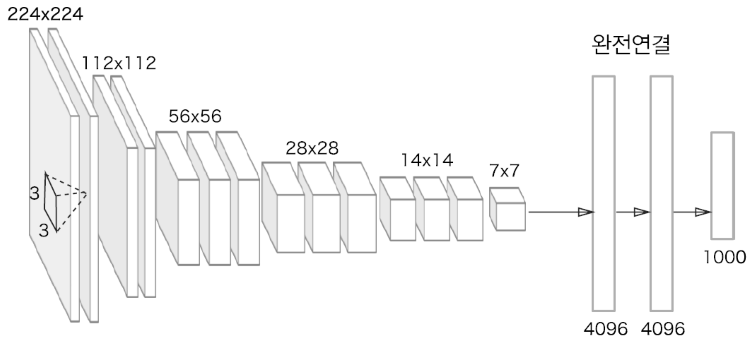

- 3x3 conv층을 연속으로 거친다는 특징이 있다
- 그리고 2~4회 연속으로 conv층을 거치고 풀링으로 크기를 절반으로 줄인다

### 8.2.3 GoogLeNet

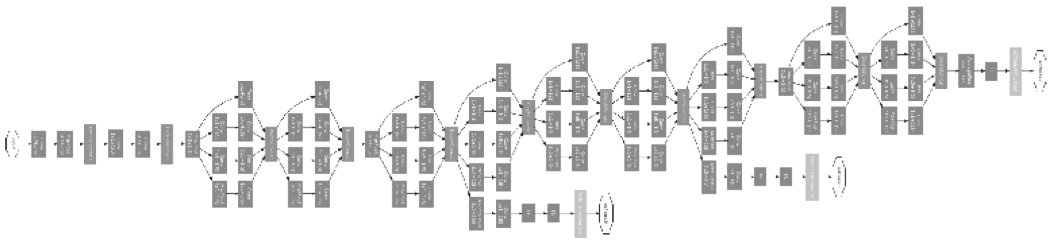

- 세로 방향 깊이뿐 아니라 가로 깊이 방향도 깊다는 것이 특징
- 가로 방향에 폭이 있는 구조를 인셉션 구조라 한다

<br/>

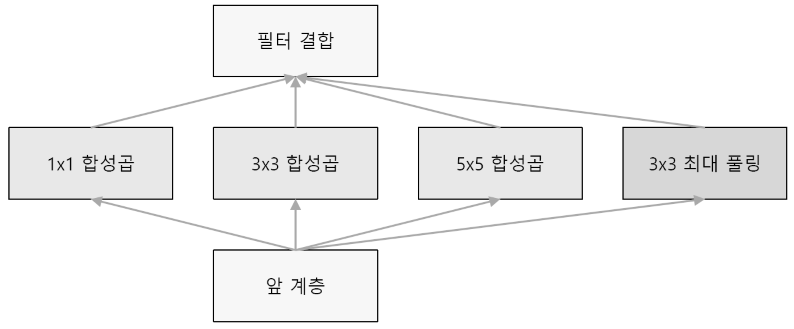

### 8.2.4 ResNet

- 딥러닝에서 층이 지나치게 깊을 경우 학습이 잘 되지 않고 성능이 떨어지는 경우가 대다수였는데 이 문제를 해결하기 위해 스킵 커넥션이라는 기법을 사용하였다

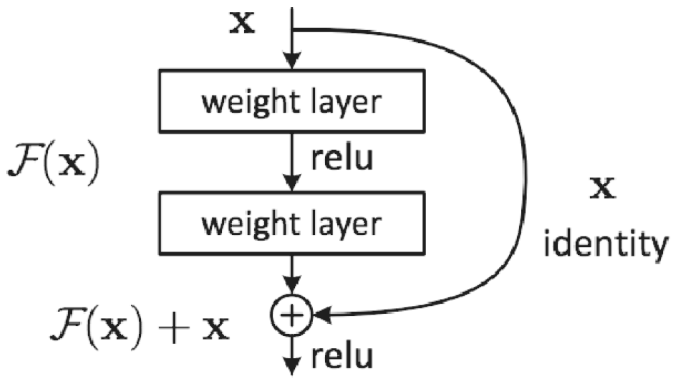

- 스킵 커넥션이란 입력 데이터를 합성곱 계층을 건너뛰어 출력에 바로 더하는 구조
- 이를 통해 역전파 때 기울기 소실을 방지하여 층이 깊어져도 학습을 효율적으로 하게 해준다

## 8.3 더 빠르게 (딥러닝 고속화)

- GPU의 발전으로 대량의 연산을 고속으로 처리 가능하게 됨.

### 8.3.1 풀어야 할 숙제

- 합성곱 계층에서 수행하는 연산은 단일 곱셈-누산이므로 딥러닝 고속화라는 주제는 **대량의 단일 곱셈-누산을 어떻게 고속으로 효율적으로 계산하느냐**의 문제이다

### 8.3.2 GPU를 활용한 고속화

- GPU의 병렬 수치 연산을 고속으로 처리할 수 있음을 이용해 딥러닝에 활용하게 되었다
- GPU는 대량의 단일 곱셈-누산과 큰 행렬의 곱 수행을 병렬 연산하는데 적합하다면 CPU는 연속적인 복잡한 계산을 잘 처리한다

### 8.3.3 분산 학습

- 학습에 걸리는 시간을 줄이고자 여러개의 GPU를 사용해 학습을 나눠 하는 아이디어가 제시됨
- GPU의 개수가 많을수록 학습이 빨라졌다

### 8.3.4 연산 정밀도와 비트 줄이기

- 계산 외에도 메모리 용량과 버스 대역폭 등 딥러닝 고속화에 병목이 될 수 있다
- 메모리 용량면에서 대량의 가중치 매개변수와 중간 데이터를 메모리에 저장해야 한다
- 버스 대역폭에서는 GPU, CPU의 버스를 흐르는 데이터가 많아지면 병목이 발생한다

  => 이를 고려해 주고받는 데이터의 비트 수를 최소로 하는 것이 바람직하다

---
- 컴퓨터는 64, 32비트로 소수를 표현하는데 많은 비트를 사용하면 계산 오차는 줄어들지만 계산에 드는 비용과 메모리 사용량이 늘고 버스 대역폭에 부담을 준다
- 딥러닝의 경우 비트 수에 크게 영향을 받지 않기에 16비트로 사용하여도 학습에 문제가 없다고 한다

  => 아 왜 성재가 넘파이를 주로 다뤘나 - 넘파이는 16비트로 수행속도가 빠르다

## 8.4 딥러닝의 활용


### 8.4.1 사물 검출

- Object Detection
- 이미지 속 사물의 위치와 클래스 식별

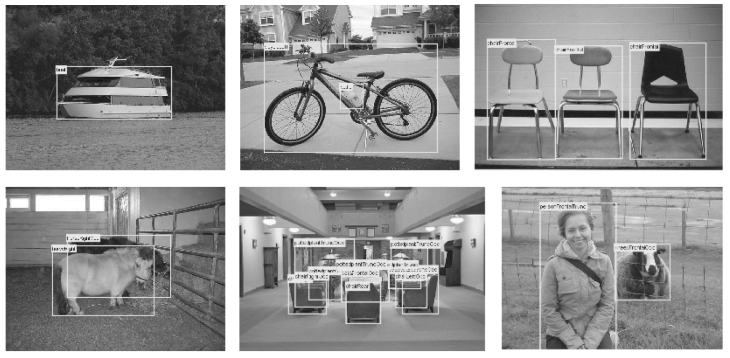


### 8.4.2 분할

- 이미지를 픽셀 단위로 분류하는 문제

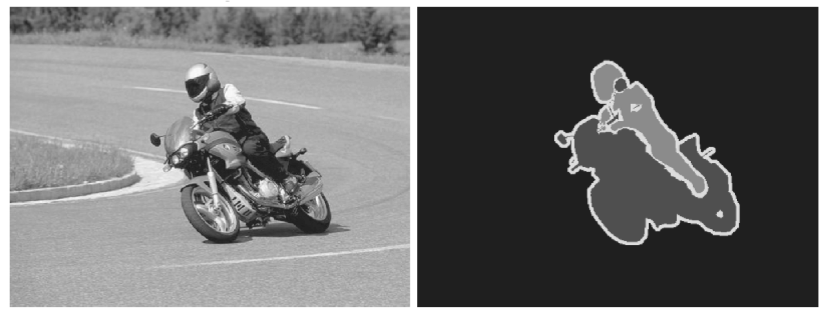

### 8.4.3 사진 캡션 생성

- 비전과 자연어 처리과 합쳐진 태스크
- 여러 형태의 데이터를 다루는 것을 멀티모달 처리라 한다

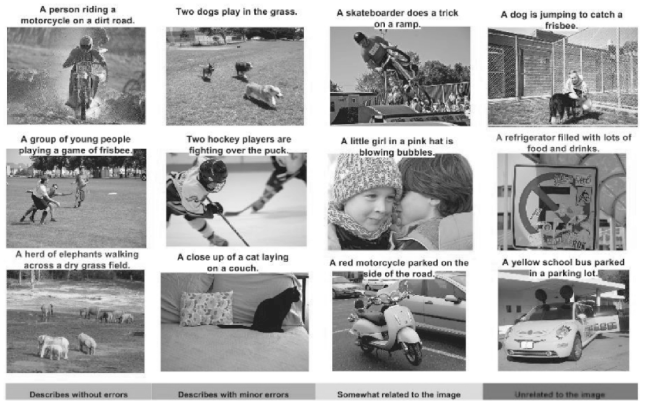

## 8.5 딥러닝의 미래

### 8.5.1 이미지 스타일 변환

### 8.5.2 이미지 생성

### 8.5.3 자율 주행

### 8.5.4 Deep Q-Network(강화학습)